In [45]:
import os
import ase
import json
import mendeleev
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path as path
from collections import defaultdict
from ase import io

In [46]:
def get_gpaw_trajectories(defect_db_path:str):
    res = defaultdict(list)
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
                res[file_].append(ase.io.read(os.path.join(this_folder, traj_file), index=":"))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return res


dataset = get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [47]:
dataset.keys()

dict_keys(['id43', 'id4', 'id34', 'id44', 'id38', 'id12', 'id31', 'id11', 'id22', 'id15', 'id16', 'id9', 'id27', 'id14', 'id7', 'id24', 'id1', 'id37', 'id13', 'id20', 'id35', 'id36', 'id17', 'id6', 'id28', 'id3', 'id45', 'id18', 'id23', 'id21', 'id5', 'id42', 'id46', 'id33', 'id25', 'id26', 'id30', 'id8', 'id19', 'id40', 'id10', 'id41', 'id29', 'id47', 'id39', 'id32', 'id0', 'id2'])

In [ ]:
id_prop = []
defect = 'id2'
data_root = path(f'datasets/cgcnn_data_format/{defect}')
data_root.mkdir() if not data_root.exists() else None


def init_atom_feat(atoms: ase.Atom):
    
    def compute_species_params(charge):
        element = mendeleev.element(charge)
        return [charge, element.atomic_volume, element.group_id, element.period]     
    
    atoms_feat = dict()
    for atom, charge in zip(atoms, atoms.get_atomic_numbers()):
        atoms_feat[atom.index] = compute_species_params(int(charge))
        
    return json.dumps(atoms_feat)


for idx, item in enumerate(dataset[defect][0]):
    # id, target 
    id_prop.append(f'{idx}, {item.get_potential_energy()}\n')
    ase.io.write(data_root.joinpath(f'{idx}.cif'), item, 'cif')
    
with open(data_root.joinpath('id_prop.csv'), 'w') as f:
    f.writelines(id_prop)
with open(data_root.joinpath('atom_init.json'), 'w') as f:
    f.writelines(init_atom_feat(dataset[defect][0][0]))

In [ ]:
# Train
%run cgcnn/main.py --optim Adam --lr 3e-3 --epochs 500 --train-size 8 --val-size 2 cgcnn/test
# %run cgcnn/main.py --epochs 500 --lr 1e-4 --train-size 6 --val-size 2 --test-size 2 cgcnn/test

In [42]:
# Inference
%run cgcnn/predict.py model_best.pth.tar cgcnn/test

=> loading model params 'model_best.pth.tar'
=> loaded model params 'model_best.pth.tar'
=> loading model 'model_best.pth.tar'
=> loaded model 'model_best.pth.tar' (epoch 493, validation 0.420257568359375)
Test: [0/1]	Time 2.109 (2.109)	Loss 1.0742 (1.0742)	MAE 0.252 (0.252)
 ** MAE 0.252


In [43]:
results = pd.read_csv('test_results.csv', index_col=0, names=['index', 'target', 'predicted'])
print(results)


           target   predicted
index                        
26    -721.574280 -721.514771
15    -721.548889 -721.515381
18    -721.558350 -721.515259
0     -719.080383 -721.514771
11    -721.520874 -721.517822
20    -721.563538 -721.516968
10    -721.487915 -721.514465
14    -721.545227 -721.516296
23    -721.568481 -721.517090
6     -721.409119 -721.507385
5     -721.363525 -721.504883
25    -721.572449 -721.515381
12    -721.531494 -721.517883
27    -721.575317 -721.514832
7     -721.435547 -721.509827
19    -721.561096 -721.516113
1     -719.564270 -721.509338
24    -721.570618 -721.516113
22    -721.566895 -721.517517
9     -721.476807 -721.513550
2     -720.713379 -721.499390
17    -721.555481 -721.514832
16    -721.551941 -721.514893
3     -721.069031 -721.503235
8     -721.434387 -721.518982
4     -721.201477 -721.502441
13    -721.541565 -721.516968
21    -721.565247 -721.517456


<AxesSubplot:xlabel='target', ylabel='predicted'>

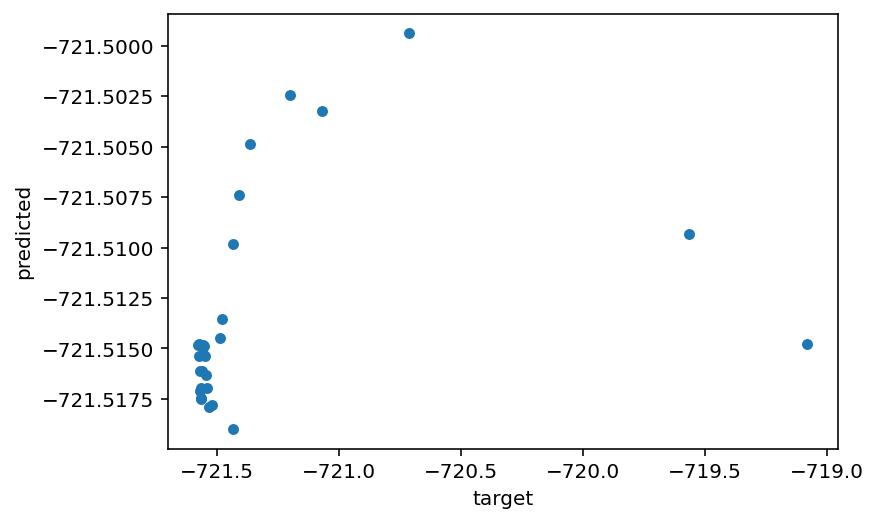

In [44]:
results.plot.scatter(x='target', y='predicted')